In [ ]:
!pip install timm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
# Prepare tea leaf disease test dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from google.colab import drive

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, num_classes):
        super(VisionTransformer, self).__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Prepare tea leaf disease dataset
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
drive.mount('/content/drive')
test_dataset = datasets.ImageFolder(root='/content/drive/My Drive/Tea Leaf Disease Datasets/val', transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_path = '/content/drive/My Drive/Colab Notebooks/new_tea_leaf_disease_classifier.pth'

# Initialize model, loss function, and optimizer
model = VisionTransformer(num_classes=len(test_dataset.classes))
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


VisionTransformer(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='n

Accuracy: 0.9804
Precision: 0.9810
Recall: 0.9804
F1 Score: 0.9804

Classification Report:
               precision    recall  f1-score   support

   Algal Leaf       0.98      1.00      0.99       200
 Brown Blight       0.94      0.99      0.97       173
  Gray Blight       0.99      0.94      0.97       200
      Healthy       0.97      0.99      0.98       200
   Helopeltis       1.00      0.96      0.98       200
Red Leaf Spot       1.00      0.99      0.99       200

     accuracy                           0.98      1173
    macro avg       0.98      0.98      0.98      1173
 weighted avg       0.98      0.98      0.98      1173



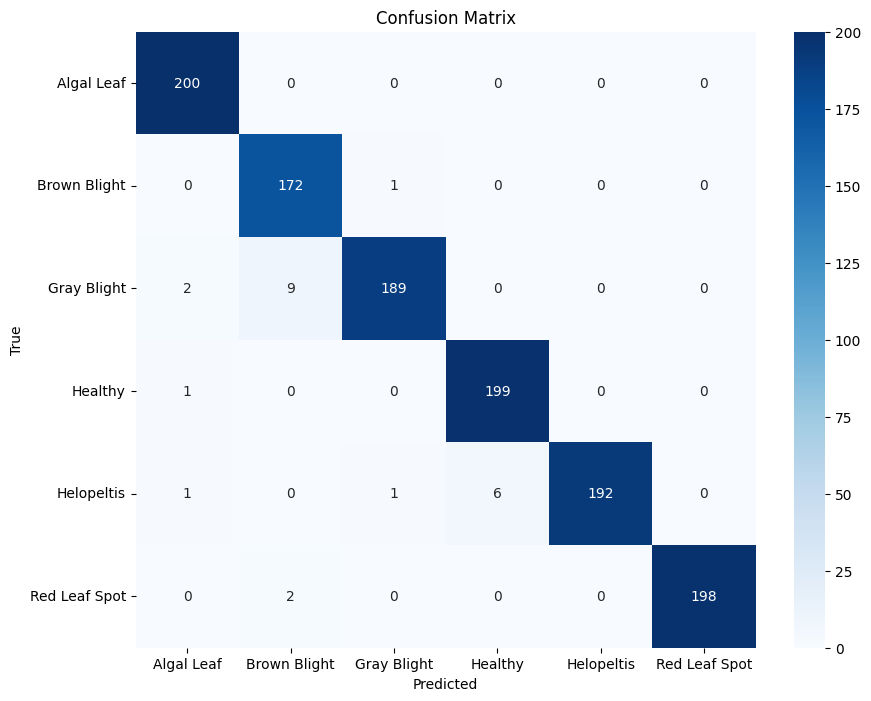

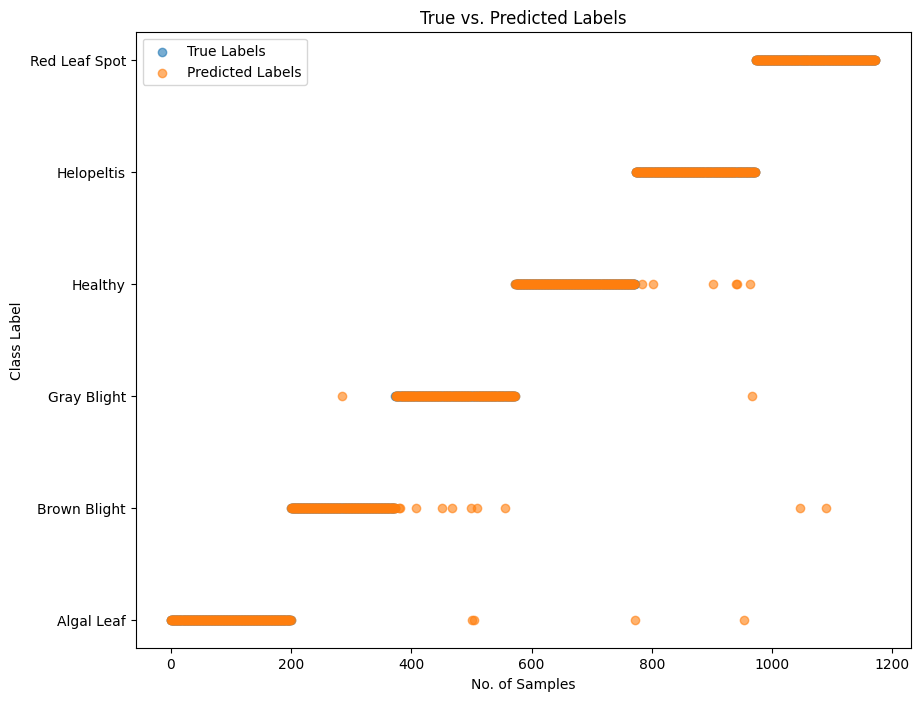

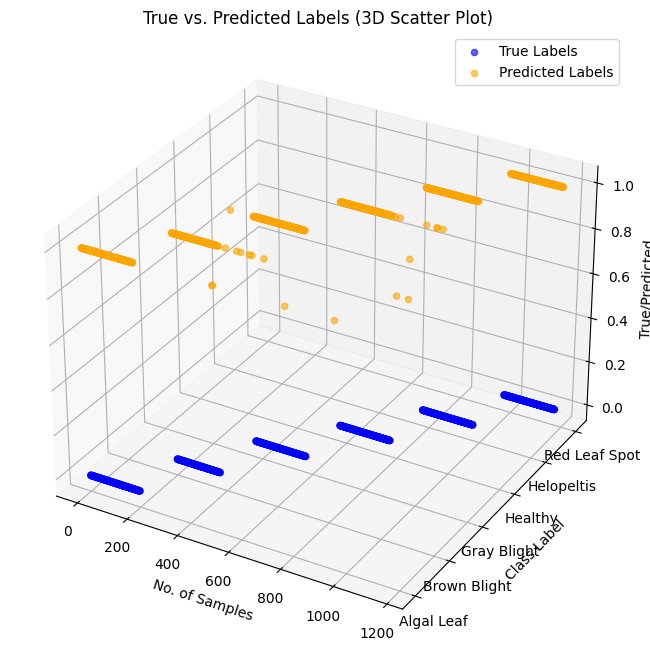

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy :.4f}')
print(f'Precision: {precision :.4f}')
print(f'Recall: {recall :.4f}')
print(f'F1 Score: {f1 :.4f}')

# Print the classification report
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names = test_dataset.classes))

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

# Plot confusion matrix with non-overlapping x-tick labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title('Confusion Matrix')

# Optionally, save the confusion matrix plot
plt.savefig('confusion_matrix.png')
plt.show()

# Plot True vs. Predicted Labels
plt.figure(figsize=(10, 8))
plt.scatter(range(len(all_labels)), all_labels, alpha=0.6, label='True Labels')
plt.scatter(range(len(all_preds)), all_preds, alpha=0.6, label='Predicted Labels')
plt.legend()
plt.xlabel('No. of Samples')
plt.ylabel('Class Label')
plt.yticks(np.arange(len(class_names)), class_names)
plt.title('True vs. Predicted Labels')
# Optionally, save the True vs. Predicted Labels plot
plt.savefig('true_vs_predicted_labels.png')
plt.show()

# Plot True vs. Predicted Labels in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter plot
ax.scatter(range(len(all_labels)), all_labels, zs=0, zdir='z', label='True Labels', c='blue', alpha=0.6)
ax.scatter(range(len(all_preds)), all_preds, zs=1, zdir='z', label='Predicted Labels', c='orange', alpha=0.6)

ax.set_xlabel('No. of Samples')
ax.set_ylabel('Class Label')
ax.set_zlabel('True/Predicted')
ax.set_yticks(np.arange(len(class_names)), class_names)
ax.set_title('True vs. Predicted Labels (3D Scatter Plot)')
ax.legend()

# Optionally, save the True vs. Predicted Labels plot
plt.savefig('true_vs_predicted_labels_3d.png')

plt.show()



In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os


# Function to predict and visualize the class of a single image
def predict_and_visualize(image_path, model, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = class_names[predicted.item()]

    # Visualize the image and the predicted label
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.savefig('outputViT.png')
    plt.show()
    # Define the class names based on the dataset's subdirectory names

class_names = test_dataset.classes

    # Example usage with an image path
image_path = '/content/drive/My Drive/20211205_160355.jpg'
predict_and_visualize(image_path, model, data_transform, class_names)

NameError: name 'test_dataset' is not defined

In [ ]:
!pip install requests
!pip install python-telegram-bot
!pip install asyncio
!pip install nest_asyncio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 2.4 MB/s eta 0:00:00


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

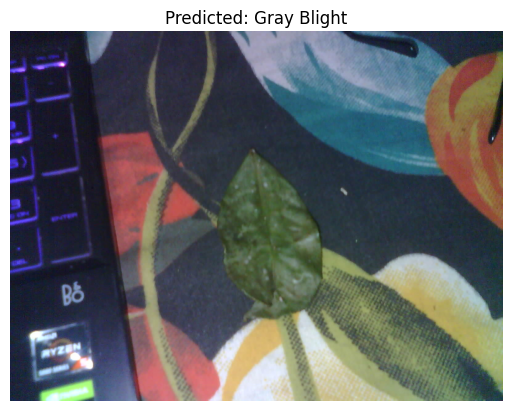

In [ ]:
import requests
from io import BytesIO
import telegram
import asyncio

import nest_asyncio
nest_asyncio.apply()

TOKEN = '7472559972:AAE3hHJXDMilVAmfnjIqrJejPJb2q2Q7Rvs'
CHAT_ID = '1175780035'

async def send_photo(image_path):
    bot = telegram.Bot(token=TOKEN)
    with open(image_path, 'rb') as photo:
        await bot.send_photo(chat_id=CHAT_ID, photo=photo)

# Function to predict and visualize the class of a single image
def predict_and_visualize(esp32_image_url, model, transform, class_names):
    model.eval()
    response = requests.get(esp32_image_url)

    if response.status_code == 200:
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        print(f"Failed to fetch image. Status code: {response.status_code}")
        return

    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = class_names[predicted.item()]

    # Visualize the image and the predicted label
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.savefig("outputEsp.png")
    plt.show()
    # Define the class names based on the dataset's subdirectory names

class_names = test_dataset.classes


# Example usage with an image URL from ESP32
esp32_image_url = "https://d510-2401-4900-7449-67c7-ec91-2d4e-951d-53cd.ngrok-free.app/saved-photo"  # Replace with the actual IP address
predict_and_visualize(esp32_image_url, model, data_transform, class_names)
asyncio.get_event_loop().run_until_complete(send_photo("outputEsp.png"))